# Sarsaの実装

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
theta_0 = np.array([[np.nan, 1, 1, np.nan],
                    [np.nan, 1, np.nan, 1],
                    [np.nan, np.nan, 1, 1],
                    [1, 1, 1, np.nan],
                    [np.nan, np.nan, 1, 1],
                    [1, np.nan, np.nan, np.nan],
                    [1, np.nan, np.nan, np.nan],
                    [1, 1, np.nan, np.nan]])

In [3]:
[a, b] = theta_0.shape
Q = np.random.rand(a, b) * theta_0
Q

array([[       nan, 0.8867676 , 0.43656628,        nan],
       [       nan, 0.82495847,        nan, 0.25628574],
       [       nan,        nan, 0.77550142, 0.2536127 ],
       [0.25000636, 0.01399757, 0.88135403,        nan],
       [       nan,        nan, 0.93927032, 0.54044564],
       [0.19976126,        nan,        nan,        nan],
       [0.2408545 ,        nan,        nan,        nan],
       [0.24342454, 0.50557655,        nan,        nan]])

## 方策パラメータtheta_0をランダム方策piに変換する関数の定義

単純に割合を計算するだけ

In [4]:
def simple_convert_into_pi_from_theta(theta):
    m, n = theta.shape
    pi = np.zeros((m, n))
    for i in range(0, m):
        pi[i, :] = theta[i, :] / np.nansum(theta[i, :])
    
    pi = np.nan_to_num(pi)
    
    return pi

pi_0 = simple_convert_into_pi_from_theta(theta_0)
pi_0

array([[0.        , 0.5       , 0.5       , 0.        ],
       [0.        , 0.5       , 0.        , 0.5       ],
       [0.        , 0.        , 0.5       , 0.5       ],
       [0.33333333, 0.33333333, 0.33333333, 0.        ],
       [0.        , 0.        , 0.5       , 0.5       ],
       [1.        , 0.        , 0.        , 0.        ],
       [1.        , 0.        , 0.        , 0.        ],
       [0.5       , 0.5       , 0.        , 0.        ]])

## ε-greedyの実装

In [5]:
def get_action(s, Q, epsilon, pi_0):
    direction = ['up', 'right', 'down', 'left']
    
    # 行動を決める
    if np.random.rand() < epsilon:
        # epsilon以下なら方策πから行動を決定
        # ※方策は改善されないので実質一様分布から選択. 
        next_direction = np.random.choice(direction, p=pi_0[s, :])
    else:
        # epsilon以上なら各s,aでの報酬に基づき評価された行動価値関数Qから次のaを選択.
        next_direction = direction[np.nanargmax(Q[s, :])]
    
    if next_direction == 'up':
        action = 0
    elif next_direction == 'right':
        action = 1
    elif next_direction == 'down':
        action = 2
    elif next_direction == 'left':
        action = 3
    return action

def get_s_next(s, a, Q, epsilon, pi_0):
    direction = ['up', 'right', 'down', 'left']
    next_direction = direction[a]
    
    # 行動から次の状態を決める
    if next_direction == 'up':
        s_next = s - 3
    elif next_direction == 'right':
        s_next = s + 1
    elif next_direction == 'down':
        s_next = s + 3
    elif next_direction == 'left':
        s_next = s - 1
    return s_next

# Q-learningによる行動価値関数Qの更新

Sarsa同様, TD誤差を用いて行動価値関数$Q(s, a)$を更新する.<br>
ただし, $Q$の更新に$a_{t+1}$は直接入らない. <br>
$Q$の評価値が正しいものだと仮定して, $\max_{a}Q(s_{t+1}, a)$として評価する.

$$
Q(s_t, a_t) \leftarrow Q(s_t, a_t) + η(R_{t+1} + γ\max_{a}Q(S_{t+1}, a) - Q(s_t, a_t)) \tag{1}
$$

一方, Sarsaの更新式は,

$$
Q(s_t, a_t) \leftarrow Q(s_t, a_t) + η(R_{t+1} + γQ(S_{t+1}, a_{t+1}) - Q(s_t, a_t)) \tag{2}
$$

ベルマン方程式$(1)$は$Q(s, a)$が正しい値であるときに成り立つ式であるので、その誤差を最小化させるようなイメージ.

$Q$の更新にする際の$a_{t+1}$がε-greedy方策に基づいていないので, Q-learningは方策オフ型アルゴリズムとなる. <br>
一方Sarsaは, 次の行動$a_{next}$における$Q$の値を決める際に、ε-greedy方策に基づくので方策オン型アルゴリズムとなる.


In [8]:
def Q_learning(s, a, r, s_next, a_next, Q, eta, gamma):
    if s_next == 8:
        # ゴールした場合は次の状態がないので、Q[s_next, a_next] = 0
        Q[s, a] = Q[s, a] + eta*(r - Q[s, a])
    else:
        # 以下、Qの更新にはs_nextと過去の経験/greedy方策で決定したa_nextを用いるので方策オン型.
        # Q-learningは更新式にa_nextが入らない. 過去の評価値をとにかく信頼する.
        Q[s, a] = Q[s, a] + eta*(r + gamma*np.nanmax(Q[s_next, :]) - Q[s, a])
        # 以下がSarsa
        #Q[s, a] = Q[s, a] + eta*(r + gamma*Q[s_next, a_next] - Q[s, a])
    return Q

# Q-learningで迷路を解く

方策勾配法と異なり、価値反復法では1エピソードごとではなく、1stepごとに更新する.

ここでは方策改善はしていない点に注意。あくまで、$s$, $a$を入力とする行動価値関数$Q$のみで次の状態・行動の学習・実行をしている.

Sarsaでは行動価値関数$Q$の更新に、ε-greedyに基づいて選択された$a_t$, $a_{t+1}$両方が考慮されていたが, Q-learningでは$a_t$のみ考慮する.

Q-learningでは$a_t$はε-greedy, $a_{t+1}$もε-greedyで選択されるが, $Q$の更新に$a_{t+1}$は使わず, $\max_{a}Q(s_{t+1}, a)$とする.<br>
あくまで$a_t \leftarrow a_{t+1}$としてアップデートするためだけにε-greedyするイミッジ. 更新式には直接入らない.<br>
Sarsaでは$Q$更新時にε-greedyに基づいて選択された$a_{t+1}$が考慮されているため、迷路で通れない場所のゆらぎを加味して評価されるが, <br>
Q-learningでは常に評価が正しくできていると仮定して次の評価値へ更新するため, 通れないところのギリギリを攻めたルート選択をするようになる. ただしその分収束は早い.

In [9]:
def goal_maze_ret_s_a_Q(Q, epsilon, eta, gamma, pi):
    s = 0
    a = a_next = get_action(s, Q, epsilon, pi)
    s_a_history = [[0, np.nan]]
    
    # 1episode終わったら状態・行動の履歴を返す.
    while(1):
        a = a_next
        s_a_history[-1][1] = a
        
        s_next = get_s_next(s, a, Q, epsilon, pi)
        
        s_a_history.append([s_next, np.nan])
        
        if s_next == 8:
            r = 1
            a_next = np.nan
        else:
            r = 0
            a_next = get_action(s_next, Q, epsilon, pi)
            
        # 1 stepごとに(各s, aごとに)Qは更新される.
        #Q = Sarsa(s, a, r, s_next, a_next, Q, eta, gamma)
        Q = Q_learning(s, a, r, s_next, a_next, Q, eta, gamma)
        
        if s_next == 8:
            break
        else:
            s = s_next
    
    return [s_a_history, Q]

## 実際にQ-learningで迷路問題を解いてみる

In [10]:
eta = 0.1
gamma = 0.9
epsilon = 0.5
v = np.nanmax(Q, axis=1) # 状態ごとに価値の最大値を求める.
is_continue = True
episode = 1
v_losses = []

while is_continue:
    print('episode : ', episode)
    
    # epsilonの値を少しずつ小さくする
    # -> だんだん経験を重視するようになる.
    epsilon /= 2
    
    # Sarsaで迷路を解き、移動した履歴と更新したQを求める
    [s_a_history, Q] = goal_maze_ret_s_a_Q(Q, epsilon, eta, gamma, pi_0)
    
    # 状態価値の変化
    new_v = np.nanmax(Q, axis=1)
    v_loss = np.sum(np.abs(new_v - v))
    v_losses.append(v_loss)
    print(v_loss)
    v = new_v
    
    print('step in the end of episode : ', len(s_a_history) - 1)
    
    episode += 1
    if episode > 100:
        break
    

episode :  1
1.3896741644155246
step in the end of episode :  174
episode :  2
0.7047929495151015
step in the end of episode :  86
episode :  3
1.4522017950948751
step in the end of episode :  760
episode :  4
0.10753095307298322
step in the end of episode :  6
episode :  5
0.096057162460288
step in the end of episode :  4
episode :  6
0.08585770464773002
step in the end of episode :  4
episode :  7
0.07687118289744105
step in the end of episode :  4
episode :  8
0.06896729108278915
step in the end of episode :  4
episode :  9
0.06202626147906304
step in the end of episode :  4
episode :  10
0.05626488959655468
step in the end of episode :  4
episode :  11
0.05434642058627215
step in the end of episode :  4
episode :  12
0.05240547312544758
step in the end of episode :  4
episode :  13
0.050464043908412304
step in the end of episode :  4
episode :  14
0.04853872704587936
step in the end of episode :  4
episode :  15
0.046641837057433466
step in the end of episode :  4
episode :  16
0.0

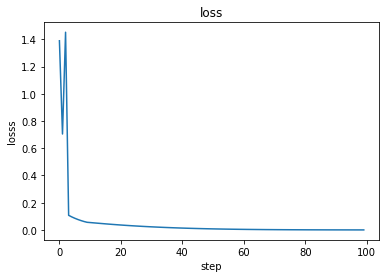

In [11]:
plt.figure()
plt.title('loss')
plt.plot(np.arange(len(v_losses)), v_losses)
plt.xlabel('step')
plt.ylabel('losss')
plt.show()